# Inverted Encoding Model

Author: Vy Vo (vy.vo@intel.com)

## Overview
We provide examples of how to use the inverted encoding model (IEM) module in BrainIAK to reconstruct features of stimuli presented to human subjects. First, a forward encoding model is estimated, mapping a set of stimulus features to the accompanying fMRI response in a population of voxels. Then, the model is inverted to allow the user to feed in new fMRI responses and predict the accompanying stimulus features.

The BrainIAK implementation allows for users to specify and fit an encoding model for stimulus features that are represented in either a 1-dimensional, circular space or a 2-dimensional space. We include examples for each of these from real fMRI studies of working memory and attention.

While decoding methods such as support vector machines (SVM) can also take fMRI responses and predict stimulus features, they rely on general purpose algorithms to learn how features are represented in the data. When the encoding model is a better description for the data than a generic decoding algorithm, it is a more efficient way to estimate the response --> stimulus mapping. Our last example simulates responses from 1D receptive fields, and uses either SVM or an IEM to predict the stimulus feature. The IEM achieves higher accuracy with less data.

## Annotated Bibliography
1. Brouwer, G.J., and Heeger, D.J. (2009). Decoding and reconstructing color from responses in human visual cortex. *Journal of Neuroscience* 29, 13992–14003. [`link`](https://doi.org/10.1523/JNEUROSCI.3577-09.2009) *Uses an inverted encoding model to reconstruct color in a continuous space, demonstrating how color is represented across a hierarchy of visual regions.*

2. Naselaris, T., Kay, K. N., Nishimoto, S., & Gallant, J. L. (2011). Encoding and decoding in fMRI. *NeuroImage* 56(2), 400–410. [`link`](https://doi.org/10.1016/j.neuroimage.2010.07.073) *A review article distinguishing between the different uses of encoding and decoding approaches for fMRI.*

3. Serences, J.T., and Saproo, S. (2012). Computational advances towards linking BOLD and behavior. *Neuropsychologia* 50, 435–446. [`link`](https://doi.org/10.1016/j.neuropsychologia.2011.07.013) *Describes the differences between encoding and decoding approaches and emphasizes how these approaches can test linking hypotheses between fMRI and behavior.*

4. Sprague, T.C., Adam, K.C.S., Foster, J.J., Rahmati, M., Sutterer, D.W., and Vo, V.A. (2018). Inverted encoding models assay population-level stimulus representations, not single-unit neural tuning. *eNeuro* 5, 1–5. [`link`](https://doi.org/10.1523/ENEURO.0098-18.2018) *Argues that inverted encoding models are most useful when using population-level stimulus representations across experimental manipulations to pointedly test psychological theories.*

5. Sprague, T.C., Boynton, G.M., and Serences, J.T. (2019). The importance of considering model choices when interpreting results in computational neuroimaging. *eNeuro* 6, 1–11. [`link`](https://doi.org/10.1523/ENEURO.0196-19.2019) *Describes the encoding model approach in the broader scope of computational models and acknowledges some important limitations.*

## Table of Contents
* <a href='#ex1'>Example 1: Reconstructing items from working memory</a>
* <a href='#ex2'>Example 2: Reconstruct 2D spatial position by contrast and attention</a>
* <a href='#ex3'>Example 3: Comparing SVM and IEM with simulated data and low trial numbers</a>
* <a href='#summary'>Summary</a>

In [1]:
import numpy as np
from brainiak.reconstruct import iem as IEM
import matplotlib.pyplot as plt
import scipy.io

The data associated with these examples are originally derived from these OSF repositories, but have been sorted and cleaned for easier use.

* Dataset 1 from Rademaker et al. 2019, Nat. Neurosci. [Download here](https://zenodo.org/record/4950267/files/RademakerEtAl2019_WM_S05_avgTime.npz?download=1).
* Dataset 2 from Itthipuripat et al. 2019, J. Neurosci. [Download here](https://zenodo.org/record/4950267/files/AL61_Bilat-V1_attnContrast.mat?download=1).


## Example 1: Reconstructing items from working memory <a id='ex1'></a>

In this study, [Rademaker et al.](https://www.nature.com/articles/s41593-019-0428-x) trained the IEM on an independent dataset where the participants viewed orientation gratings.

In the test data, the participants viewed a target orientation, and held it working memory for 12 seconds. During this delay period, a distractor grating appeared in a portion of the trials. The orientation of the distractor was randomized relative to the remembered orientation.

Using the fMRI data from the delay period, we will reconstruct both the orientation held in WM and the distractor orientation that was simultaneously being viewed. This sample data is from visual area V1.

In [2]:
# Load the fMRI data from the WM experiment
wm_data = np.load("RademakerEtAl2019_WM_S05_avgTime.npz")
print(list(wm_data.keys()))

['trn', 'trn_conds', 'tst_m', 'tst_m_conds', 'tst_d', 'tst_d_conds']


In [3]:
# Set up parameters
n_channels = 9
cos_exponent = 8
feature_resolution = 180
iem_obj0 = IEM.InvertedEncoding1D(n_channels, cos_exponent, 
                                  stimulus_mode='halfcircular',
                                  channel_density=feature_resolution)

In [4]:
iem_obj0 = iem_obj0.fit(wm_data['trn'], wm_data['trn_conds'])

The quality and interpretability of your stimulus reconstructions all depend on how you set up the channels, or basis functions, in the model. In order to ensure that you can accurately reconstruct stimuli at all portions in the area where you have presented stimuli, you will want to evenly space your basis functions in that region so that the sum of all the basis functions is constant across the feature space. You also will likely want to ensure some overlap between the basis functions.

(9, 180)


Text(0.5, 1.0, 'Sum across channels')

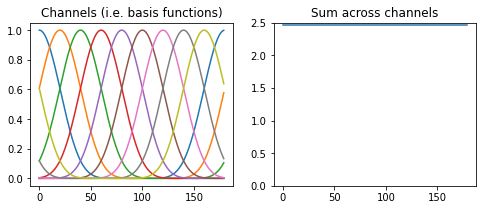

In [5]:
# Let's visualize the basis functions.
channels = iem_obj0.channels_
feature_axis = iem_obj0.channel_domain
print(channels.shape)

plt.figure(figsize=[8, 3])
plt.subplot(1, 2, 1)
for i in range(0, channels.shape[0]):
    plt.plot(feature_axis, channels[i,:])
plt.title('Channels (i.e. basis functions)')
plt.subplot(1, 2, 2)
plt.plot(np.sum(channels, 0))
plt.ylim(0, 2.5)
plt.title('Sum across channels')

Now that we have trained the IEM, we can test it on our two different conditions: holding an orientation in working memory, or viewing it as a distractor. Let's first look at the memory condition.

In [6]:
# Test the model on remembered orientation
tst_mem_tc = wm_data['tst_m']
n_tst_mem, n_vox = tst_mem_tc.shape
mpred_features = iem_obj0._predict_feature_responses(wm_data['tst_m'])

In order to collapse across trials from all the different orientations, we recenter all the reconstructions to be centered at the same point. To do this, we circularly shift the reconstruction based on the presented target orientation on that trial. We can then plot the average reconstruction across trials.

Text(0.5, 1.0, 'Orientation reconstructed from WM')

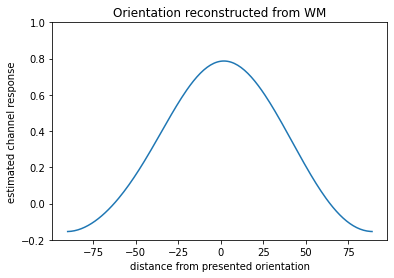

In [7]:
mpred_features_centered = np.ones((feature_resolution, n_tst_mem)) * np.nan
# Re-center all the reconstructions to a common point
shift_to = 90
for trial in range(n_tst_mem):
    mpred_features_centered[:, trial] = np.roll(mpred_features[:, trial],
                                                shift_to - int(wm_data['tst_m_conds'][trial]))

avg_feats = mpred_features_centered.mean(axis=1)
plt.plot(iem_obj0.channel_domain - shift_to, avg_feats)
plt.ylim([-0.2, 1.0])
plt.xlabel('distance from presented orientation')
plt.ylabel('estimated channel response')
plt.title('Orientation reconstructed from WM')

We can see that there is a robust representation of the remembered orientation in the data.

Next, we look at the reconstruction of the distractor orientation during the working memory delay period. Recall that this is the orientation that is being visually presented to the participant.

Text(0.5, 1.0, 'Reconstruction of WM and distractor orientations')

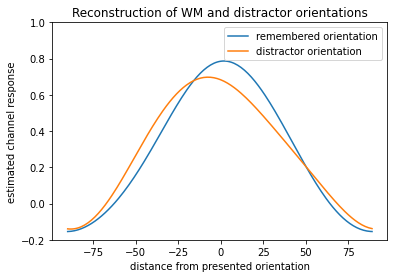

In [8]:
# Test the model on the viewed orientation (WM distractor)
tst_dist_tc = wm_data['tst_d']
n_tst_dist, _ = tst_dist_tc.shape
pred_features = iem_obj0._predict_feature_responses(wm_data['tst_d'])
# Re-center all the reconstructions to a common point
pred_features_centered = np.ones((feature_resolution, n_tst_dist)) * np.nan
for trial in range(n_tst_dist):
    pred_features_centered[:, trial] = np.roll(pred_features[:, trial],
                                               shift_to - int(wm_data['tst_d_conds'][trial]))

dist_avg_feats = pred_features_centered.mean(axis=1)

plt.plot(iem_obj0.channel_domain - shift_to, avg_feats)
plt.plot(iem_obj0.channel_domain - shift_to, dist_avg_feats)
plt.ylim([-0.2, 1.0])
plt.xlabel('distance from presented orientation')
plt.ylabel('estimated channel response')
plt.legend(['remembered orientation', 'distractor orientation'])
plt.title('Reconstruction of WM and distractor orientations')

We see that the distractor orientation is simultaneously represented in the same data!

Read more about these data in the [full paper](https://www.nature.com/articles/s41593-019-0428-x).

Rademaker, R., Chunharas, C., Serences, J.T. 2019. Coexisting representations of sensory and mnemonic information in human visual cortex. Nature Neuroscience 22:8.

## Example 2: Reconstructing 2D spatial representations with attention and contrast changes <a id='ex2'></a>

[Itthipuripat et al. 2019](https://www.jneurosci.org/content/39/31/6162) collected data from participants as they viewed flickering checkerboard stimuli presented at a range of contrasts (0-70%, logarithmically spaced) on either the left or right of the screen. They either attended to an occasional change in contrast at the stimulus position ("attend stimulus") or at the central fixation point ("attend fixation"). These contrast change trials are excluded from the data, so the sensory input is equated across conditions.

The IEM will be trained on an independent dataset, in which participants viewed checkerboards as they appeared at many locations across the screen. Then we will test the IEM, i.e. reconstruct the stimulus, under the different contrast and attention conditions.

In [9]:
# Load the fMRI data
data = scipy.io.loadmat('AL61_Bilat-V1_attnContrast.mat')
trn_conds = data['trn_conds']  # position in space for 128 trials
# flip to cartesian coordinates to make life easier
trn_conds[:,1] = trn_conds[:,1]*-1
trn = data['trn']  # matrix of (trials, voxels)

The test data have different conditions than the training data. There are four independent variables in these data based on the values in the following columns: 
- In column 1, whether the stimulus was on the left (1) or right (2) side of the screen. 
- In column 2, the logarithmically spaced stimulus contrast from lowest (1) to highest (6). 
- In column 3, the task instruction to attend to fixation (1) or the stimulus (2).
- In column 4, whether the target was present (1) or not (0).

In [10]:
# Note there are several different conditions in the test data.
tst_conds = data['tst_conds']
tst = data['tst']
attn_conds = np.unique(tst_conds[:, 2])
stim_contrasts = np.unique(tst_conds[:, 1])

In [11]:
# Set up parameters
n_channels = [9, 5]  # channels in the x, y directions
cos_exponent = 5
stimx, stimy = [-17/2, 17/2], [-5, 5]
stim_res = [171, 101]
npixels = stim_res[0] * stim_res[1]
stim_size = 1.449
chanx, chany = [-6, 6], [-3, 3]

In [12]:
iem_obj = IEM.InvertedEncoding2D(stim_xlim=stimx, stim_ylim=stimy,
                                 stimulus_resolution=stim_res,
                                 stim_radius=stim_size,
                                 chan_xlim=chanx, chan_ylim=chany,
                                 channel_exp=7)

The quality and interpretability of your stimulus reconstructions all depend on how you set up the channels, or basis functions, in the model. In order to ensure that you can accurately reconstruct stimuli at all portions in the area where you have presented stimuli, you will want to evenly space your basis functions in that region. You also will likely want to ensure some overlap between the basis functions.

There are two pre-built functions to create a 2D grid of basis functions, to use a rectangular grid or a triangular grid. A triangular grid is more space-efficient, so let's use that.

Note you will need to define these basis functions before you can fit the model. Otherwise it will throw an error.

In [13]:
basis_fcns, basis_centers = iem_obj.define_basis_functions_sqgrid(n_channels)

To visualize these, you will need to reshape the second dimension into the 2D pixel space where the stimuli are represented.

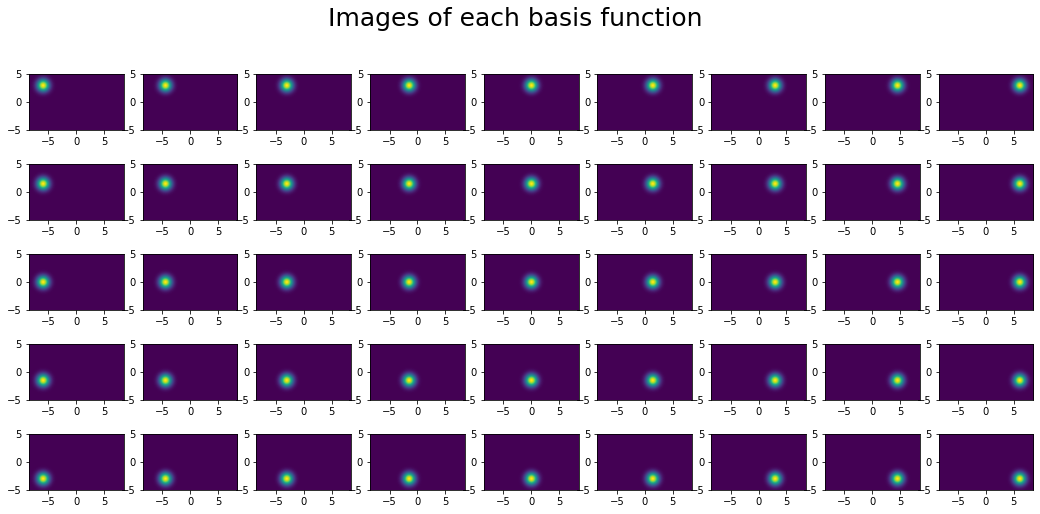

In [14]:
f, ax = plt.subplots(n_channels[1], n_channels[0], figsize=[18, 8])
i = 0
for ii in range(n_channels[1]):
    for jj in range(n_channels[0]):
        ax[ii, jj].imshow(basis_fcns[i, :].reshape(stim_res[1], 
                                                   stim_res[0]),
                          extent=[stimx[0], stimx[1], stimy[0], stimy[1]])
        i += 1
plt.suptitle('Images of each basis function', fontsize=25)
plt.show()

To check how well the basis functions cover the stimulus domain, we can sum across all the basis functions.

Text(0.5, 1.0, 'Spatial coverage of basis functions')

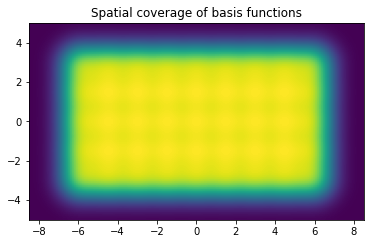

In [15]:
sum_fcns = basis_fcns.sum(axis=0).reshape(stim_res[1], stim_res[0])
plt.imshow(sum_fcns, extent=[stimx[0], stimx[1], stimy[0], stimy[1]])
plt.title('Spatial coverage of basis functions')

Next, we want to map channel responses for each voxel. To do this, we fit a standard general linear model (GLM), where the design matrix is the channel activations for each trial. Below, you can see the design matrix of these trial activations in the channel domain (x-axis: trials, y-axis: channels, color: activations).

(128, 45)


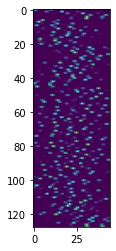

In [16]:
C = iem_obj._define_trial_activations(trn_conds)
plt.imshow(C)
print(C.shape)

Whenever you run the fit() function, the trial-wise channel activations will be created automatically, and the GLM will be fit on the training data and feature labels. Using this, we can then predict the feature responses on a set of test data.

In [17]:
iem_obj = iem_obj.fit(trn, trn_conds)
stim_reconstructions = iem_obj.predict_feature_responses(tst)

### Average feature reconstructions across trials

In this experiment, we are not specifically interested in separating trials by whether stimuli were on the left or the right. Instead, we're interested in how the activation in the model-based reconstruction varies with the experimental manipulation of contrast and attended location. For the sake of visualization and quantification, we can simply average across the trials of interest. Below we separated the trials by contrast and attention location, but averaged across trials where the stimulus appeared on the left side of the screen and the target was not present (to ensure that overall contrast is identical across averaged trials).

In [18]:
vmin, vmax = 0, 0
mean_recons = np.zeros((stim_contrasts.size, attn_conds.size, npixels))

for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        thisidx = np.argwhere((tst_conds[:, 0] == 1) &
                              (tst_conds[:, 1] == contrast) &
                              (tst_conds[:, 2] == attn_cond) &
                              (tst_conds[:, 3] == 0))
        rs = np.mean(stim_reconstructions[:, thisidx], axis=1)
        if rs.min() < vmin:
            vmin = rs.min()
        if rs.max() > vmax:
            vmax = rs.max()
        mean_recons[ss, aa, :] = rs.squeeze()

Finally, we plot the data as a function of:
 
1) whether subjects were attending to the stimulus or fixation, and
2) the contrast of the stimulus (across six levels).

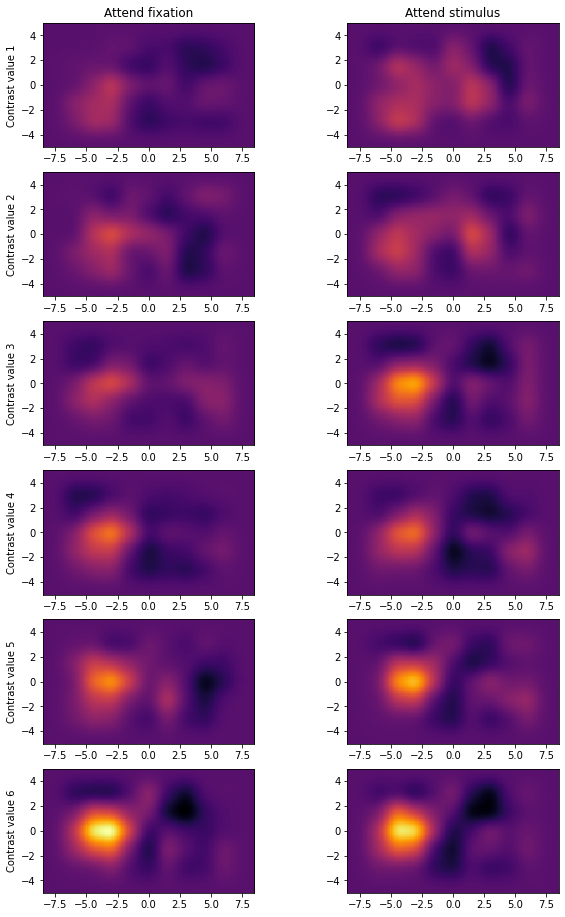

In [19]:
f, ax = plt.subplots(6, 2, figsize=(10,16))
for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        ax[ss, aa].imshow(mean_recons[ss, aa, :].\
                          reshape(stim_res[1], stim_res[0]),
                          origin='lower', interpolation='none',
                          cmap='inferno',
                          extent=[stimx[0], stimx[1], stimy[0], stimy[1]],
                          vmin=vmin, vmax=vmax)
        if contrast == stim_contrasts[0]:
            if attn_cond == 1:
                ax[ss, aa].set_title('Attend fixation')
            elif attn_cond == 2:
                ax[ss, aa].set_title('Attend stimulus')
        if attn_cond == 1:
            ax[ss, aa].set_ylabel('Contrast value {}'.format(contrast))

These data suggest that increasing the contrast leads to stronger activation of the stimulus. They also suggest that the effect of attention is greatest at low contrast levels -- e.g. at contrast level 3, we see a clear enhancement when the participant is attending to the stimulus compared to when they are attending fixation.

However, since this is single-participant data, these effects should be quantified across a group of subjects.

Read the full results in [the paper](https://www.jneurosci.org/content/39/31/6162).

Itthipuripat, S., Sprague, T.,C., Serences, J.T. 2019. Functional MRI and EEG Index Complementary Attentional Modulations. J. Neurosci. 31:6162-6179.

## Example 3: Comparing SVM and IEM with simulated data and low trial numbers <a id='ex3'></a>

If the assumptions of the forward encoding model are a good match to the data, it can outperform common decoding algorithms such as support vector machine (SVM) classifiers. Here, we simulate fMRI responses from a set of 1D receptive fields with Gaussian-like tuning along an orientation space.

Then, we train an IEM and SVM on the same data: simulated responses from these voxel receptive fields to 7 orientation stimuli (`stim_vals`). We then score the accuracy of each model by calculating the coefficient of determination, R<sup>2</sup>. Note that although the IEM can provide a continuous stimulus reconstruction, we are simply taking the feature value with the maximal response to be the predicted orientation. The SVM is a 7-way classifier.

In [20]:
import brainiak.utils.fmrisim as fmrisim

np.random.seed(100)
range_start = 0
range_stop = 180
feature_range = (range_start, range_stop)
n_stim_classes = 7
feature_resolution = 180
stim_vals = np.linspace(0, feature_resolution - (feature_resolution/n_stim_classes), n_stim_classes).astype(int)

In [21]:
# Define IEM
iem_sim = IEM.InvertedEncoding1D(6, 5, stimulus_mode='halfcircular', 
                                 range_start=range_start, range_stop=range_stop, 
                                 channel_density=180)

# Define SVM
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Create a classifier model for the training set
svc_model = LinearSVC(C=n_stim_classes, max_iter=5000) #, dual=True)
scaler = StandardScaler()

We need to define a function which can calculate R<sup>2</sup> in a circular space. A version of this function is included with the 1D IEM module, but we need it here to score the SVM.

In [22]:
from brainiak.utils.utils import circ_dist

def circ_score(true_features, pred_features):
    # multiply features by 2 because it's 180 space. otherwise doesn't wrap properly
    pred_features = pred_features * 2
    true_features = true_features * 2

    ssres = (circ_dist(np.deg2rad(true_features),
                       np.deg2rad(pred_features)) ** 2).sum()
    sstot = (circ_dist(np.deg2rad(true_features),
                       np.ones(true_features.size) * scipy.stats.circmean(
                           np.deg2rad(true_features))) ** 2).sum()
    score_value = (1 - ssres / sstot)

    return score_value

We simulate two sources of uniform noise: consistent noise in the receptive field responses (`rf_noise`) and trial-wise noise. This relies on some simple functions packaged with BrainIAK that can provide the user ways to test how the IEM behaves with known inputs.

In [23]:
def fit_models(n_train, n_tst, iem_sim=iem_sim, svc_model=svc_model, n_voxels=24,
               rf_noise=0.1, trial_noise=0.5):
    trn_stim = np.repeat(stim_vals, n_train / n_stim_classes).astype(int)
    tst_stim = np.repeat(stim_vals, n_tst / n_stim_classes).astype(int)
    voxel_RFs, voxel_tuning = fmrisim.generate_1d_gaussian_rfs(n_voxels,
                                                               feature_resolution,
                                                               feature_range,
                                                               rf_size=30,
                                                               random_tuning=True, 
                                                               rf_noise=rf_noise)
    trnd = fmrisim.generate_1d_rf_responses(voxel_RFs, trn_stim, 
                                            feature_resolution, feature_range,
                                            trial_noise=trial_noise)
    trn = scaler.fit_transform(trnd)
    # IEM
    iem_sim = iem_sim.fit(trnd.T, trn_stim)
    tstd = fmrisim.generate_1d_rf_responses(voxel_RFs, tst_stim, 
                                            feature_resolution, feature_range,
                                            trial_noise=trial_noise)
    tst = scaler.fit_transform(tstd)
    pred_feature = iem_sim.predict(tstd.T)
    iem_r2 = iem_sim.score(tstd.T, tst_stim)
    # Linear SVM
    svc_model.fit(trn.T, trn_stim)
    svc_pred = svc_model.predict(tst.T)
    svc_score = circ_score(tst_stim, svc_pred)
    
    return iem_r2, svc_score, trn, tst

The data simulations are repeated 25 times, and the R<sup>2</sup> values are averaged across these repeats to account for any random variability.

In [24]:
nt_list = np.arange(n_stim_classes, n_stim_classes*15, n_stim_classes)
n_repeats = 25
iem_score = np.zeros((n_repeats, nt_list.size))
svm_score = np.zeros((n_repeats, nt_list.size))
for i, nt in enumerate(nt_list):
    for j in range(n_repeats):
        try:
            iem_score[j, i], svm_score[j, i], trn, tst = fit_models(nt, n_stim_classes*3,
                                                                    n_voxels=15,
                                                                    rf_noise=1.5,
                                                                    trial_noise=1.5)
        except:
            print(i, j)
#     print('%i\t%0.2f\t%0.2f' % (nt, iem_score[:, i].mean(), svm_score[:, i].mean()))

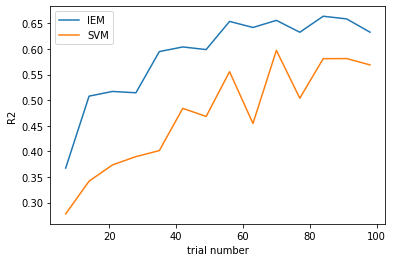

In [25]:
plt.plot(nt_list, iem_score.mean(axis=0))
plt.plot(nt_list, svm_score.mean(axis=0))
plt.xlabel('trial number')
plt.ylabel('R2')
plt.legend(['IEM', 'SVM'])

We can see that both models improve with more trials, but the IEM consistently outperforms the SVM in all cases.

Next, we'll hold the number of trials constant and vary how much noise is added to the receptive fields.

In [26]:
rfn_list = np.arange(1.5, 0.15, -0.05)
n_repeats = 25
iem_score2 = np.zeros((n_repeats, rfn_list.size))
svm_score2 = np.zeros((n_repeats, rfn_list.size))
for i, rfn in enumerate(rfn_list):
    for j in range(n_repeats):
        try:
            iem_score2[j, i], svm_score2[j, i], trn, tst = fit_models(28, n_stim_classes*3,
                                                                    n_voxels=15,
                                                                    rf_noise=rfn,
                                                                    trial_noise=1)
        except:
            print(i, j)
#     print('%0.2f\t%0.2f\t%0.2f' % (rfn, iem_score[:, i].mean(), svm_score[:, i].mean()))

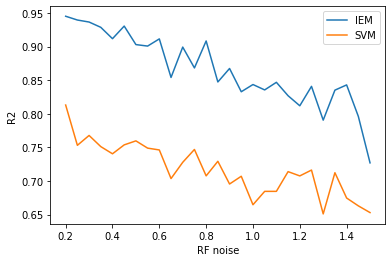

In [27]:
plt.plot(rfn_list, iem_score2.mean(axis=0))
plt.plot(rfn_list, svm_score2.mean(axis=0))
plt.xlabel('RF noise')
plt.ylabel('R2')
plt.legend(['IEM', 'SVM'])

Again, we see that both models perform worse with higher noise, but the IEM consistently outperforms the SVM.

## Summary <a id='summary'></a>

The IEM allows us to build a decoder that relies on a specific hypothesis about how a stimulus is encoded. In cases where this hypothesis is a better characterization of how the stimulus evokes fMRI responses, the IEM can outperform standard decoding approaches like the SVM. In addition, the specific form of the IEM allows for a natural way to visualize a decoded stimulus, i.e. to reconstruct the stimulus that must have been seen on any given trial.